# Определение эмоциональной окраски твитов с помощью BERT

Сегодня мы не будем кодить руками обучение BERT, а покажем, как, максимально просто, максимально быстро, найти готовый предобученный BERT и, минимальным количеством кода, дофайнтюнить его для решения вашей задачи.

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (51/51), done.
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
     |████████████████████████████████| 24.2 MB 47.7 MB/s 
     |████████████████████████████████| 6.0 MB 36.1 MB/s 
     |████████████████████████████████| 304 kB 38.3 MB/s 
     |████████████████████████████████| 10.1 MB 32.4 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 451 kB 51.9 MB/s 
     |████████████████████████████████| 181 kB 50.4 MB/s 
     |████████████████████████████████| 628 kB 22.3 MB/s 
     |████████████████████████████████| 8.2

## Установка библиотек

In [4]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 4.3 MB/s 
     |████████████████████████████████| 131 kB 33.4 MB/s 
     |████████████████████████████████| 895 kB 31.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
     |████████████████████████████████| 8.5 MB 38.3 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 138 kB 21.1 MB/s 
     |████████████████████████████████| 127 kB 37.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla K80


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

* дата публикации;
* имя автора;
* текст твита;
* класс, к которому принадлежит текст (положительный, отрицательный, нейтральный);
* количество добавлений сообщения в избранное;
* количество ретвитов (количество копирований этого сообщения другими пользователями);
* количество друзей пользователя;
* количество пользователей, у которых данный юзер в друзьях (количество фоловеров);
* количество листов, в которых состоит пользователь.
 

In [7]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

In [8]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
18000,409376525889204224,1386437944,RonyLiss,"@kto_to__tam @mudak1999 @msdarren16 ага,наприм...",1,0,0,0,2878,289,429,0
104190,411118922063032320,1386853363,adamantia88,Правду Настя сказала. Если буду все встречи на...,1,0,0,0,1912,54,30,0
78419,410720433957515264,1386758356,rrrraaaaaaaaaa,"Ахахахха, психанула на ваню, хотя он не мне ск...",1,0,0,0,431,77,101,0
85157,410792587763937280,1386775559,VAS_KALLAS,"Игра ""найдите алкоголиков"" ахаххахахахааххахах...",1,0,0,0,4521,49,55,0
31760,409743183023579136,1386525362,mmv93,@zarifulin_k Вот сразу видно: человек домашку ...,1,0,0,0,5578,107,183,0


 Теперь давайте приготовим наши данные так, чтобы их можно было подать в BERT для дообучения. Обратите внимание на специальные токены — "CLS" и "SEP", которые мы будем добавлять в начало и конец наших предложений. Как вы помните, именно такой формат нужен BERT для того, чтобы работать с входными предложениями

In [9]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [10]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [11]:
print(sentences[1000])

[CLS] Дим, ты помогаешь мне, я тебе, все взаимно, все правильно) [SEP]


In [12]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [13]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Теперь импортируем токенизатор для BERT, который превратит наши тексты в набор токенов, соответствующих тем, что встречались в словаре предобученной модели.

In [14]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 316966.33B/s]


['[CLS]', '@', 'anne', '##t', '##20', '##14', '##1', 'б', '##л', '##а', '##г', '##о', '##р', '##о', '##д', '##н', '##ы', '##е', 'с', '##л', '##ов', '##а', 'и', 'б', '##л', '##а', '##г', '##о', '##р', '##о', '##д', '##н', '##ы', '##и', 'п', '##о', '##р', '##ы', '##в', '.', '.', 'н', '##е', 'з', '##на', '##ю', ',', 'р', '##е', '##з', '##у', '##л', '##ь', '##т', '##а', '##т', '##и', '##в', '##н', '##ы', '##и', 'л', '##и', '(', '(', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений.Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц. 
(как я понял, это из-за того, что берт решает 2 задачи (маскинга и пред-ния след предлож) и тут мы показывает, что решать будем только одну из задач
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг. Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Более длинные предложения мы будем обрезать до 100 токенов, а для более коротких предложений использовать паддинг.

In [15]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Хорошо, теперь нам нужно поделить наши данные на тренировку и валидацию.

In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [17]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [18]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

Дальше мы превращаем наши данные в pytorch тензоры, и давайте посмотрим на формат, в котором у нас лежат наши лэйблы. Обратите внимание на формат лейблов в наших данных. Мы подаём не просто list() из нулей и единиц, а мы подаём list(list()). Это нужно для того, чтобы поддерживать также возможность работы с задачами, где мы каждому объекту присваиваем несколько классов. Например, если бы мы хотели присваивать некоторые метки (лейблы) тем для наших предложений (ну, или скорее для наших текстов), то мы хотели бы уметь присваивать несколько тем одному тексту. 

In [19]:
train_labels

tensor([[1],
        [0],
        [1],
        ...,
        [1],
        [0],
        [1]])

 Нужно создать итераторы с помощью DataLoader. Данные по батчам мы будем разбивать произвольно с помощью RandomSampler (здесь). Разбитие данных на батчи позволит нам более эффективно использовать память во время обучения, поскольку нам не придётся загружать весь датасет в память.

In [20]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [21]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации. А затем — дофайнтюнить полученную сеть на наших данных. Мы берём готовую модификацию BERT для классификации из pytorch-transformers, она называется "BertForSequenceClassification". Импортируем её. Это обычный BERT с добавленным одним линейным слоем для классификации.

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [ ]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

 Теперь давайте чуть-чуть подробнее рассмотрим сам процесс файнтюнинга. Как мы помним, первый токен в каждом предложении в наших данных — это метка "CLS". Скрытое состояние, относящееся к этой метке, должно содержать в себе агрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом должен быть вектор со скрытым состоянием, относящийся к метке "CLS". Дополнительный полносвязный слой, который мы добавили, имеет размер ["hidden state", "количество классов"] — это двухмерный вектор. В нашем случае, количество классов равно "2", то есть, на выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска", "отрицательная эмоциональная окраска". 


 В целом, замораживание слоёв BERT обычно не сильно сказывается на итоговом качестве, однако стоит помнить о тех случаях, когда домен для предобучения и дообучения был разным. Например, когда мы предобучили нашу сеть на каких-то официальных текстах (на правовых актах или на научных статьях), а дообучаем её на, например, твитах, на неформальной лексике. В таких случаях лучше тренировать все слои сети, не замораживая ничего.

In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:34<00:00, 12637369.47B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Отлично, теперь давайте обсудим гиперпараметры для обучения нашей модели. Авторы статьи про BERT советуют выбирать learning rate из следующего списка:  5 * 10^-5 , 3 * 10^-5, 2 * 10^-5 . А количество эпох делать не слишком большим (2 или 4 будет достаточно). Мы же пробуем дообучать нашу сеть за одну эпоху, а в качестве learning rate давайте выберем 2 * 10^-5
 

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



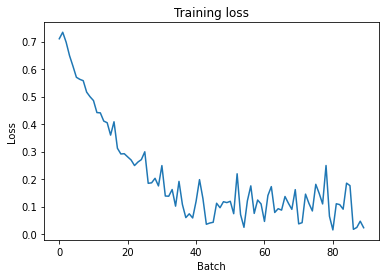

KeyboardInterrupt: ignored

In [26]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))



In [28]:

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 96.42%


# Оценка качества на отложенной выборке

In [29]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [30]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(test_labels != test_preds),
    len(test_labels)
))

Мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Кроме того, обратите внимание, что мы не тюнили параметры и использовали сравнительно маленький размеченный корпус, чтобы получить accuracy больше 98%. Тем не менее, если не делать дообучение под конкретную задачу вовсе, то получить хорошее качество вряд ли выйдет. Кроме того, на этом семинаре мы познакомились с библиотекой pytorch-transformers, которая позволяет использовать готовые обёртки над моделями, специально созданными для решения той или иной задачи. Использовать BERT при решении повседневных NLP задач совсем не трудно. Не нужно даже вручную скачивать веса модели, искать их где-то в интернете — библиотека абсолютно всё сделает за вас. Отбросив необходимость небольшой предобработки текстов, сложность применения предобученного BERT с использованием библиотеки pytorch-transformers оказывается не сильно больше, чем — ну, например, импортировать лог-регрессию из sk-learn, и примените её, а качество итоговое получается гораздо выше. Вы можете использовать предобученный BERT, GPT-2 или какие-то другие сети для решения других задач — не только классификации, но и чего-то более сложного, например, для решения задачи вопросно-ответного поиска, или, может быть, машинного перевода или выделения именованных сущностей. Единственное, что вам нужно будет сделать — это импортировать другую модель из pytorch-transformers и подготовить ваши данные для обучения в чуть-чуть другом формате. Успеха в дальнейшей работе с pytorch-transformers!

### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [ ]:
import pandas as pd

dataset = pd.read_csv('datasets/bert_sentiment_analysis/homework/IMDB_Dataset.csv')

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?